In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.stats.multitest as smm

In [2]:
ROOT = '/data1/wgs_APA/validation_res/'
GEM0 = 'gem0/'
GEM1 = 'gem1/'
MAAPER_OUT = 'MAAPER_out/'

# Get the list of selected genes

In [3]:
genes = [d.split('_')[0] for d in os.listdir(f'{ROOT}{GEM1}{MAAPER_OUT}')]
genes

['DEDD',
 'CREB5',
 'KDM2B',
 'CEP44',
 'RELB',
 'HOXA4',
 'SLC26A6',
 'PHAX',
 'PROX1',
 'NIP7',
 'UTRN',
 'PPP2CB',
 'HPS1',
 'GSC2',
 'TOR1B',
 'GLYR1',
 'PPARD',
 'KLF9',
 'NKX6-3',
 'UBE2D2',
 'KIN',
 'negative',
 'ZNF215',
 'NFIB',
 'ENSA',
 'NUP214',
 'TEAD3',
 'ZNF530',
 'RDH11',
 'MED1',
 'RELN',
 'ASCL2',
 'ZNF527',
 'MECOM',
 'HNRNPC',
 'MRPL9',
 'RBM15B',
 'HOMEZ',
 'MLEC',
 'IFITM2',
 'RPL37',
 'TAF15',
 'TFDP1',
 'ZNF623',
 'TWIST1',
 'ZNF232',
 'HOXA3',
 'NR5A1',
 'ETS1',
 'ZDHHC6',
 'ZEB1',
 'KCNIP3',
 'MEX3D',
 'LRRC14',
 'LBX2',
 'FOXE3',
 'ZNF345',
 'FNBP4',
 'SENP3',
 'DHX33',
 'HAUS7',
 'BRIP1',
 'EPB41L5',
 'RPS20',
 'SIX6',
 'HLCS',
 'PPP1R12A',
 'PIR',
 'BIRC2']

In [4]:
genes_GP_apa_df = pd.read_csv('genes_GP_apa_df.csv', index_col=0)
genes_GP_apa_df.head()

,term_name,genes,APA_effect
1,nuclear lumen,SPECC1,-3.416269
2,nuclear lumen,RPS6KA1,5.813447
3,nuclear lumen,CLK3,2.457411
4,nuclear lumen,DEDD,-13.204945
5,nuclear lumen,INTS13,1.644397


In [5]:
data_dir = '/data1/wgs_APA/MAAPER_out'
genes_dirs = os.listdir(data_dir)

genes_pas = {}
for gene in genes_dirs:
    try:
        gene_name = gene.split('_')[0]
        gene_pas = pd.read_csv(data_dir + "/" + gene + '/gene.txt' ,sep='\t', index_col=0)
        genes_pas[gene_name] = gene_pas
    except:
        continue
    
shapes = []
for pgene in genes_pas:
    print(pgene)
    shapes.append(genes_pas[pgene].shape)

# for each gene in genes_pas, lets filter the genes_pas['gene'] to only keep rows with npas > 1

genes_pas_filtered = {}
for gene in genes_pas:
    genes_pas_filtered[gene] = genes_pas[gene][genes_pas[gene]['npas'] > 1]

In [ ]:
genes_pas['HNRNPC']

,npas,pval,RLDu,RLDi,REDu,REDu.pval,REDi,REDi.pval,nread.c1.1,nread.c2.1
gene,,,,,,,,,,
ACTB,2,9.990000e-01,0.00235,NaN,0.0452,1.000000e+00,NaN,NaN,13338,39
ALDOA,2,4.550000e-03,0.23900,NaN,34.5000,2.330000e-02,NaN,NaN,7187,38
ANP32B,4,1.520000e-26,0.74600,1.51,4.7600,4.960000e-27,4.32,2.360000e-16,6684,64
ARF5,2,8.330000e-17,5.54000,NaN,6.8900,6.640000e-17,NaN,NaN,1641,28
ARPC3,2,1.310000e-13,1.58000,NaN,102.0000,2.330000e-12,NaN,NaN,3025,27
...,...,...,...,...,...,...,...,...,...,...
SLC25A5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2692,28
SNRPB,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4193,32
TUBA1B,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12115,32


In [ ]:
genes_pas['HNRNPC'].columns

Index(['npas', 'pval', 'RLDu', 'RLDi', 'REDu', 'REDu.pval', 'REDi',
       'REDi.pval', 'nread.c1.1', 'nread.c2.1'],
      dtype='object')

In [58]:
def get_affected_genes_num(gene):
    global genes_pas
    tmp = genes_pas[gene]
    # remove NAs on REDu columns
    tmp = tmp[~tmp['REDu'].isna()]
    # keep significant rows based on REDu.pval column
    tmp = tmp[tmp['REDu.pval'] < 0.05]
    tmp_positive = tmp[tmp['REDu'] > 0]
    tmp_negative = tmp[tmp['REDu'] < 0]

    return (tmp_positive.shape[0], tmp_positive['REDu'].median()), (tmp_negative.shape[0], tmp_negative['REDu'].median())

In [59]:
get_affected_genes_num('TAF15')

((91, 4.59), (10, -1.72))

In [23]:
# drop name 'negative' from list genes
idx = genes.index('negative')
genes.pop(idx)

'negative'

In [78]:
results = []
for gene in genes:
    # Call your function
    try:
        positive_info, negative_info = get_affected_genes_num(gene) 
        # Create a dictionary for this gene
        gene_dict = {
            'Gene': gene,
            'lengthened_genes': positive_info[0],
            'distal_APA_effect': positive_info[1],
            'shortened_genes': negative_info[0],
            'proximal_APA_effect': negative_info[1]
        }
        
        # Append to results
        results.append(gene_dict)
    except:
        continue

# Convert list of dictionaries to DataFrame
JW_df = pd.DataFrame(results)

# Display DataFrame
print(JW_df)


        Gene  lengthened_genes  distal_APA_effect  shortened_genes  \
0       DEDD                 7              4.920              102   
1      CREB5                74              6.215               34   
2      KDM2B                72              3.775               33   
3      CEP44                90              4.585               18   
4       RELB                38              1.760               83   
..       ...               ...                ...              ...   
63      SIX6                51              2.390               86   
64      HLCS                53              2.510               50   
65  PPP1R12A                75              2.330              148   
66       PIR               103              4.130               56   
67     BIRC2                76              3.360               31   

    proximal_APA_effect  
0                -8.030  
1                -2.900  
2                -2.330  
3                -2.655  
4                -2.290  
.. 

In [79]:
JW_df

,Gene,lengthened_genes,distal_APA_effect,shortened_genes,proximal_APA_effect
0,DEDD,7,4.920,102,-8.030
1,CREB5,74,6.215,34,-2.900
2,KDM2B,72,3.775,33,-2.330
3,CEP44,90,4.585,18,-2.655
4,RELB,38,1.760,83,-2.290
...,...,...,...,...,...
63,SIX6,51,2.390,86,-2.000
64,HLCS,53,2.510,50,-2.480
65,PPP1R12A,75,2.330,148,-2.565
66,PIR,103,4.130,56,-2.700


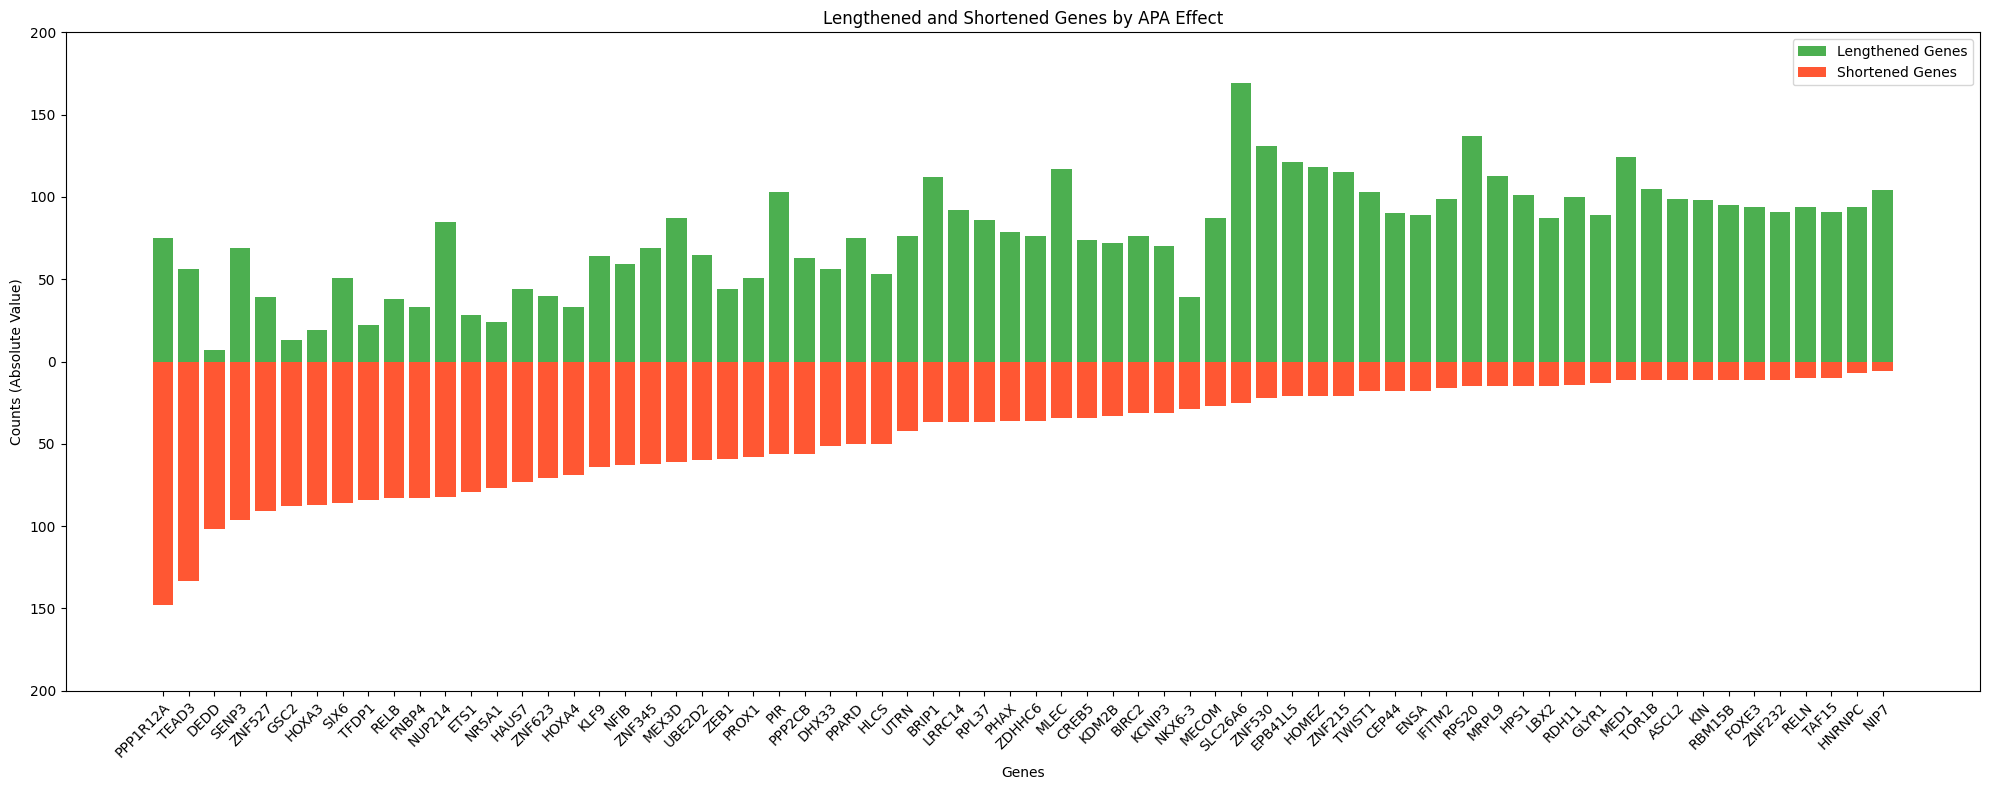

In [81]:
df = JW_df.copy()
# Sort DataFrame first based on shortened genes in descending order and then based on lengthened genes also in descending order
df = df.sort_values(by=['shortened_genes', 'lengthened_genes'], ascending=[False, False])

# Values for plotting
genes = df['Gene']
lengthened_genes = df['lengthened_genes']
shortened_genes = df['shortened_genes']
distal_APA_effects = df['distal_APA_effect']
proximal_APA_effects = df['proximal_APA_effect']

# Create a new figure and set the size
plt.figure(figsize=(20, 8))

# Create bar plots
# Bar plots for lengthened genes on top
plt.bar(genes, lengthened_genes, color='#4CAF50', label='Lengthened Genes')  # Using green-ish color

# Bar plots for shortened genes on the bottom
plt.bar(genes, -np.array(shortened_genes), color='#FF5733', label='Shortened Genes')  # Using red-ish color

# Adding labels and title
plt.xlabel('Genes')
plt.ylabel('Counts (Absolute Value)')
plt.title('Lengthened and Shortened Genes by APA Effect')

# Customize y-ticks to show as positive
yticks = plt.yticks()[0]
plt.yticks(yticks, [str(abs(int(y))) for y in yticks])

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")

# Adding legend
plt.legend()

# # Show APA effect labels on each bar
# for i, (lg, sg, da, pa) in enumerate(zip(lengthened_genes, shortened_genes, distal_APA_effects, proximal_APA_effects)):
#     plt.text(i, lg, f"{da:.2f}", ha='center', va='bottom', size=10)
#     plt.text(i, -sg, f"{pa:.2f}", ha='center', va='top', size=10)

# Tight layout to ensure everything fits
plt.tight_layout()

# Display the plot
plt.show()


In [68]:

def adjust_pvalues(df):
    """
    Adjust the p-values in the 'REDu.pval' column of the dataframe using the FDR method.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing the 'REDu.pval' column.
    
    Returns:
    - pd.DataFrame: Original DataFrame with an additional 'adjusted.pval' column.
    """
    
    # Extract the p-values from the dataframe
    pvals = df['REDu.pval'].values
    
    # Adjust the p-values using the Benjamini-Hochberg procedure
    adjusted_pvals = smm.multipletests(pvals, method='fdr_bh')[1]
    
    # Add the adjusted p-values to the dataframe
    df['adjusted.pval'] = adjusted_pvals
    
    return df

In [96]:
# Initialize dictionaries to store values
stratified_data = {}
gene_list = []


for gene in genes:
    if gene != 'negative':
        try:
            filepath = f'{ROOT}{GEM0}{MAAPER_OUT}{gene}_res/gene.txt'
            df = pd.read_csv(filepath, sep='\t')
            
            # Remove rows with NaN or infinite values
            df = df[~df['REDu'].isin([np.nan, np.inf, -np.inf])]
            # Adjust p-values (assuming you have a function for this)
            df = adjust_pvalues(df)
            
            # Filter based on significance
            df = df[(df['REDu.pval'] < 0.05) & (df['adjusted.pval'] < 0.01)]
            
            # Stratification
            tmp_positive = df[df['REDu'] > 0]
            tmp_negative = df[df['REDu'] < 0]
            
            # Store into dictionary
            stratified_data[gene] = {
                'lengthened_genes': tmp_positive.shape[0],
                'distal_APA_effect': tmp_positive['REDu'].median(),
                'shortened_genes': tmp_negative.shape[0],
                'proximal_APA_effect': tmp_negative['REDu'].median()
            }
            
            gene_list.append(gene)
            
        except Exception as e:
            print(f"An error occurred with gene {gene}: {e}")
            continue

# Create the DataFrame from the dictionary
gem0_stratified_df = pd.DataFrame.from_dict(stratified_data, orient='index')
gem0_stratified_df.reset_index(inplace=True)
gem0_stratified_df.columns = ['Gene', 'lengthened_genes', 'distal_APA_effect', 'shortened_genes', 'proximal_APA_effect']
gem0_stratified_df


,Gene,lengthened_genes,distal_APA_effect,shortened_genes,proximal_APA_effect
0,PPP1R12A,282,1.560,276,-1.415
1,TEAD3,268,1.465,323,-1.430
2,DEDD,291,1.650,328,-1.345
3,SENP3,318,1.510,321,-1.360
4,ZNF527,262,1.495,320,-1.285
...,...,...,...,...,...
63,ZNF232,255,1.550,270,-1.510
64,RELN,256,1.635,303,-1.430
65,TAF15,248,1.520,344,-1.355
66,HNRNPC,335,1.520,262,-1.575


In [95]:
# Initialize dictionaries to store values
stratified_data = {}
gene_list = []


for gene in genes:
    if gene != 'negative':
        try:
            filepath = f'{ROOT}{GEM1}{MAAPER_OUT}{gene}_res/gene.txt'
            df = pd.read_csv(filepath, sep='\t')
            
            # Remove rows with NaN or infinite values
            df = df[~df['REDu'].isin([np.nan, np.inf, -np.inf])]
            # Adjust p-values (assuming you have a function for this)
            df = adjust_pvalues(df)
            
            # Filter based on significance
            df = df[(df['REDu.pval'] < 0.05) & (df['adjusted.pval'] < 0.01)]
            
            # Stratification
            tmp_positive = df[df['REDu'] > 0]
            tmp_negative = df[df['REDu'] < 0]
            
            # Store into dictionary
            stratified_data[gene] = {
                'lengthened_genes': tmp_positive.shape[0],
                'distal_APA_effect': tmp_positive['REDu'].median(),
                'shortened_genes': tmp_negative.shape[0],
                'proximal_APA_effect': tmp_negative['REDu'].median()
            }
            
            gene_list.append(gene)
            
        except Exception as e:
            print(f"An error occurred with gene {gene}: {e}")
            continue

# Create the DataFrame from the dictionary
gem1_stratified_df = pd.DataFrame.from_dict(stratified_data, orient='index')
gem1_stratified_df.reset_index(inplace=True)
gem1_stratified_df.columns = ['Gene', 'lengthened_genes', 'distal_APA_effect', 'shortened_genes', 'proximal_APA_effect']
gem1_stratified_df


An error occurred with gene BIRC2: [Errno 2] No such file or directory: '/data1/wgs_APA/validation_res/gem1/MAAPER_out/BIRC2_res/gene.txt'


,Gene,lengthened_genes,distal_APA_effect,shortened_genes,proximal_APA_effect
0,PPP1R12A,540,1.305,195,-1.750
1,TEAD3,548,1.275,206,-1.715
2,DEDD,237,1.610,269,-1.480
3,SENP3,475,1.190,196,-1.635
4,ZNF527,383,1.270,212,-1.620
...,...,...,...,...,...
62,ZNF232,186,1.795,307,-1.380
63,RELN,593,1.290,207,-1.690
64,TAF15,225,1.660,267,-1.390
65,HNRNPC,410,1.230,198,-1.850


In [101]:
# Create a new DataFrame with the same columns
new_row_df = pd.DataFrame({
    'Gene': ['BIRC2'],
    'lengthened_genes': [0],
    'distal_APA_effect': [0],
    'shortened_genes': [0],
    'proximal_APA_effect': [0]
})

# Concatenate the original DataFrame with the new DataFrame
gem1_stratified_df = pd.concat([gem1_stratified_df, new_row_df], ignore_index=True)

/tmp/ipykernel_56979/588356283.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(tick) for tick in ticks])


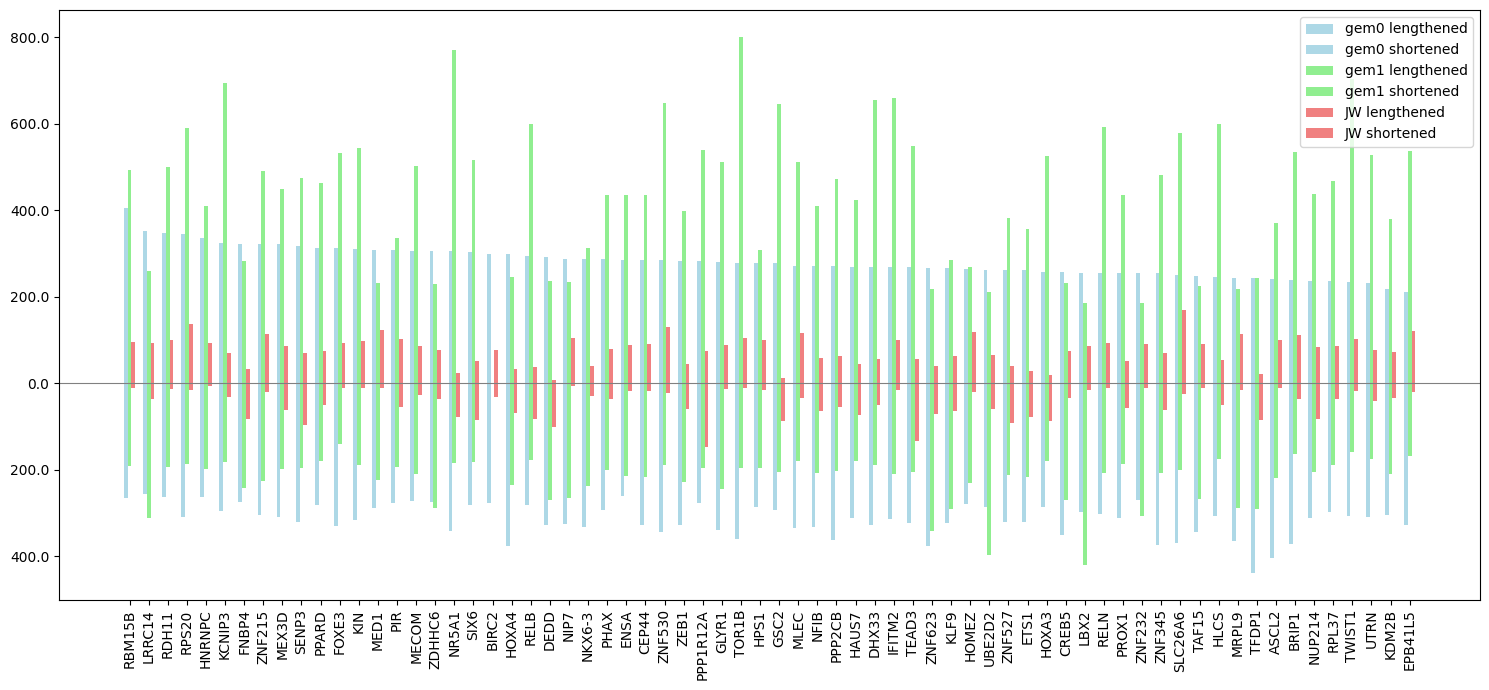

In [104]:
sorted_df = gem0_stratified_df.sort_values(by=['lengthened_genes', 'shortened_genes'], ascending=[False, True])
sorted_genes = sorted_df['Gene']

gem0_stratified_df = gem0_stratified_df.set_index('Gene').loc[sorted_genes].reset_index()
gem1_stratified_df = gem1_stratified_df.set_index('Gene').loc[sorted_genes].reset_index()
JW_df = JW_df.set_index('Gene').loc[sorted_genes].reset_index()

# Bar positions
N = len(gem0_stratified_df)
ind = np.arange(N)
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 7))

# Bars for gem0_stratified_df
p1 = ax.bar(ind - width, gem0_stratified_df['lengthened_genes'], width, color='lightblue', label='gem0 lengthened')
p2 = ax.bar(ind - width, -gem0_stratified_df['shortened_genes'], width, color='lightblue', label='gem0 shortened')

# Bars for gem1_stratified_df
p3 = ax.bar(ind, gem1_stratified_df['lengthened_genes'], width, color='lightgreen', label='gem1 lengthened')
p4 = ax.bar(ind, -gem1_stratified_df['shortened_genes'], width, color='lightgreen', label='gem1 shortened')

# Bars for JW_df
p5 = ax.bar(ind + width, JW_df['lengthened_genes'], width, color='lightcoral', label='JW lengthened')
p6 = ax.bar(ind + width, -JW_df['shortened_genes'], width, color='lightcoral', label='JW shortened')

# Label the bars with APA effect values
# for i, v in enumerate(gem0_stratified_df['distal_APA_effect']):
#     ax.text(ind[i] - width, gem0_stratified_df['lengthened_genes'][i], str(round(v, 2)), color='blue', va='bottom', ha='center')

# for i, v in enumerate(gem0_stratified_df['proximal_APA_effect']):
#     ax.text(ind[i] - width, -gem0_stratified_df['shortened_genes'][i], str(round(v, 2)), color='blue', va='top', ha='center')

# More labels, etc.
ax.axhline(0, color='grey', lw=0.8)
ax.set_xticks(ind)
ax.set_xticklabels(sorted_genes, rotation='vertical')
ax.legend()

# Fix y-axis labels to display positive values on both sides
ticks = ax.get_yticks()
ax.set_yticklabels([abs(tick) for tick in ticks])

plt.tight_layout()
plt.show()


In [107]:
gem0_stratified_df['DataSource'] = 'gem0'
gem1_stratified_df['DataSource'] = 'gem1'
JW_df['DataSource'] = 'JW'

# Combine the three DataFrames into one
combined_df = pd.concat([gem0_stratified_df, gem1_stratified_df, JW_df], ignore_index=True)
combined_df

,Gene,lengthened_genes,distal_APA_effect,shortened_genes,proximal_APA_effect,DataSource
0,RBM15B,406,1.500,265,-1.530,gem0
1,LRRC14,353,1.400,256,-1.500,gem0
2,RDH11,347,1.380,262,-1.425,gem0
3,RPS20,344,1.440,309,-1.380,gem0
4,HNRNPC,335,1.520,262,-1.575,gem0
...,...,...,...,...,...,...
199,RPL37,86,3.185,37,-2.400,JW
200,TWIST1,103,5.590,18,-2.525,JW
201,UTRN,76,3.410,42,-3.085,JW
202,KDM2B,72,3.775,33,-2.330,JW


/home/aiden/anaconda3/envs/apa_wgs/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


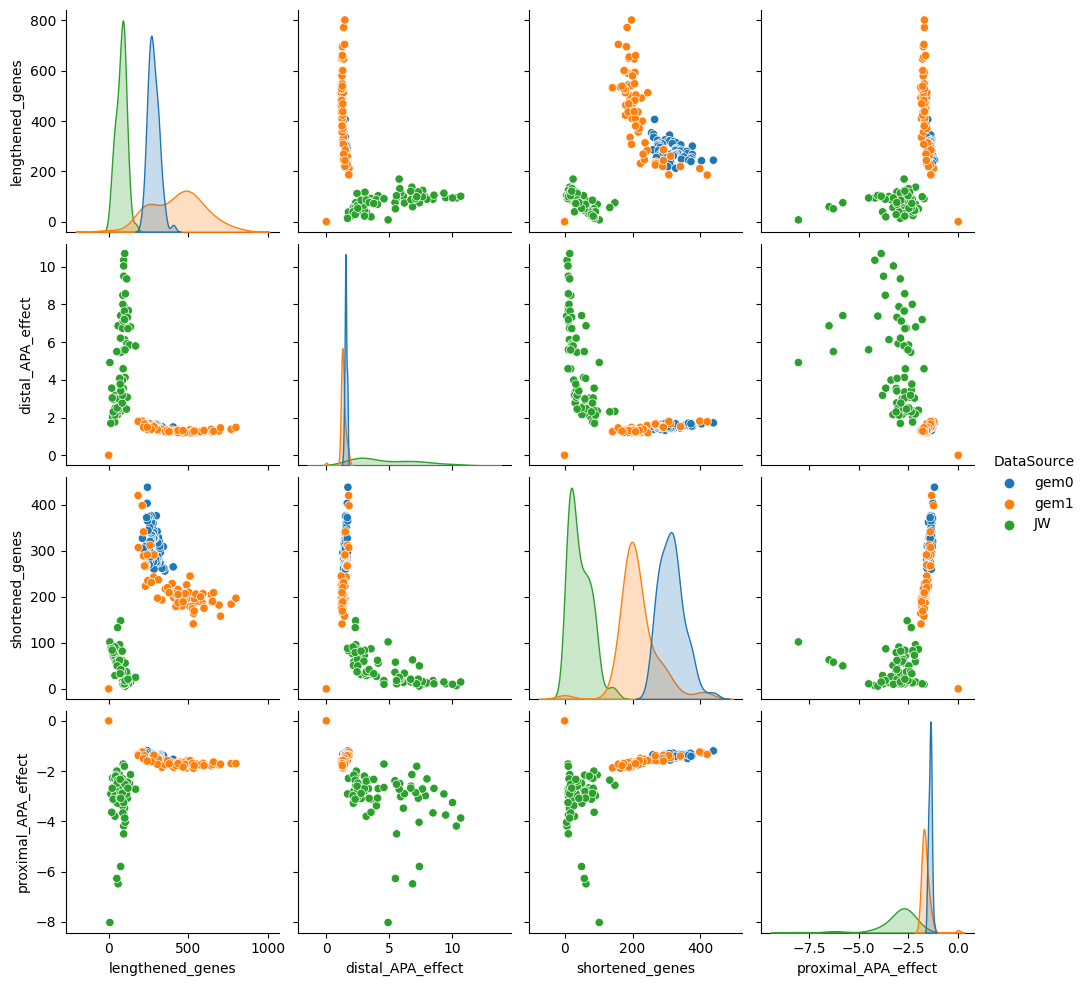

In [109]:
sns.pairplot(data=combined_df, hue='DataSource', diag_kind='kde')
plt.show()


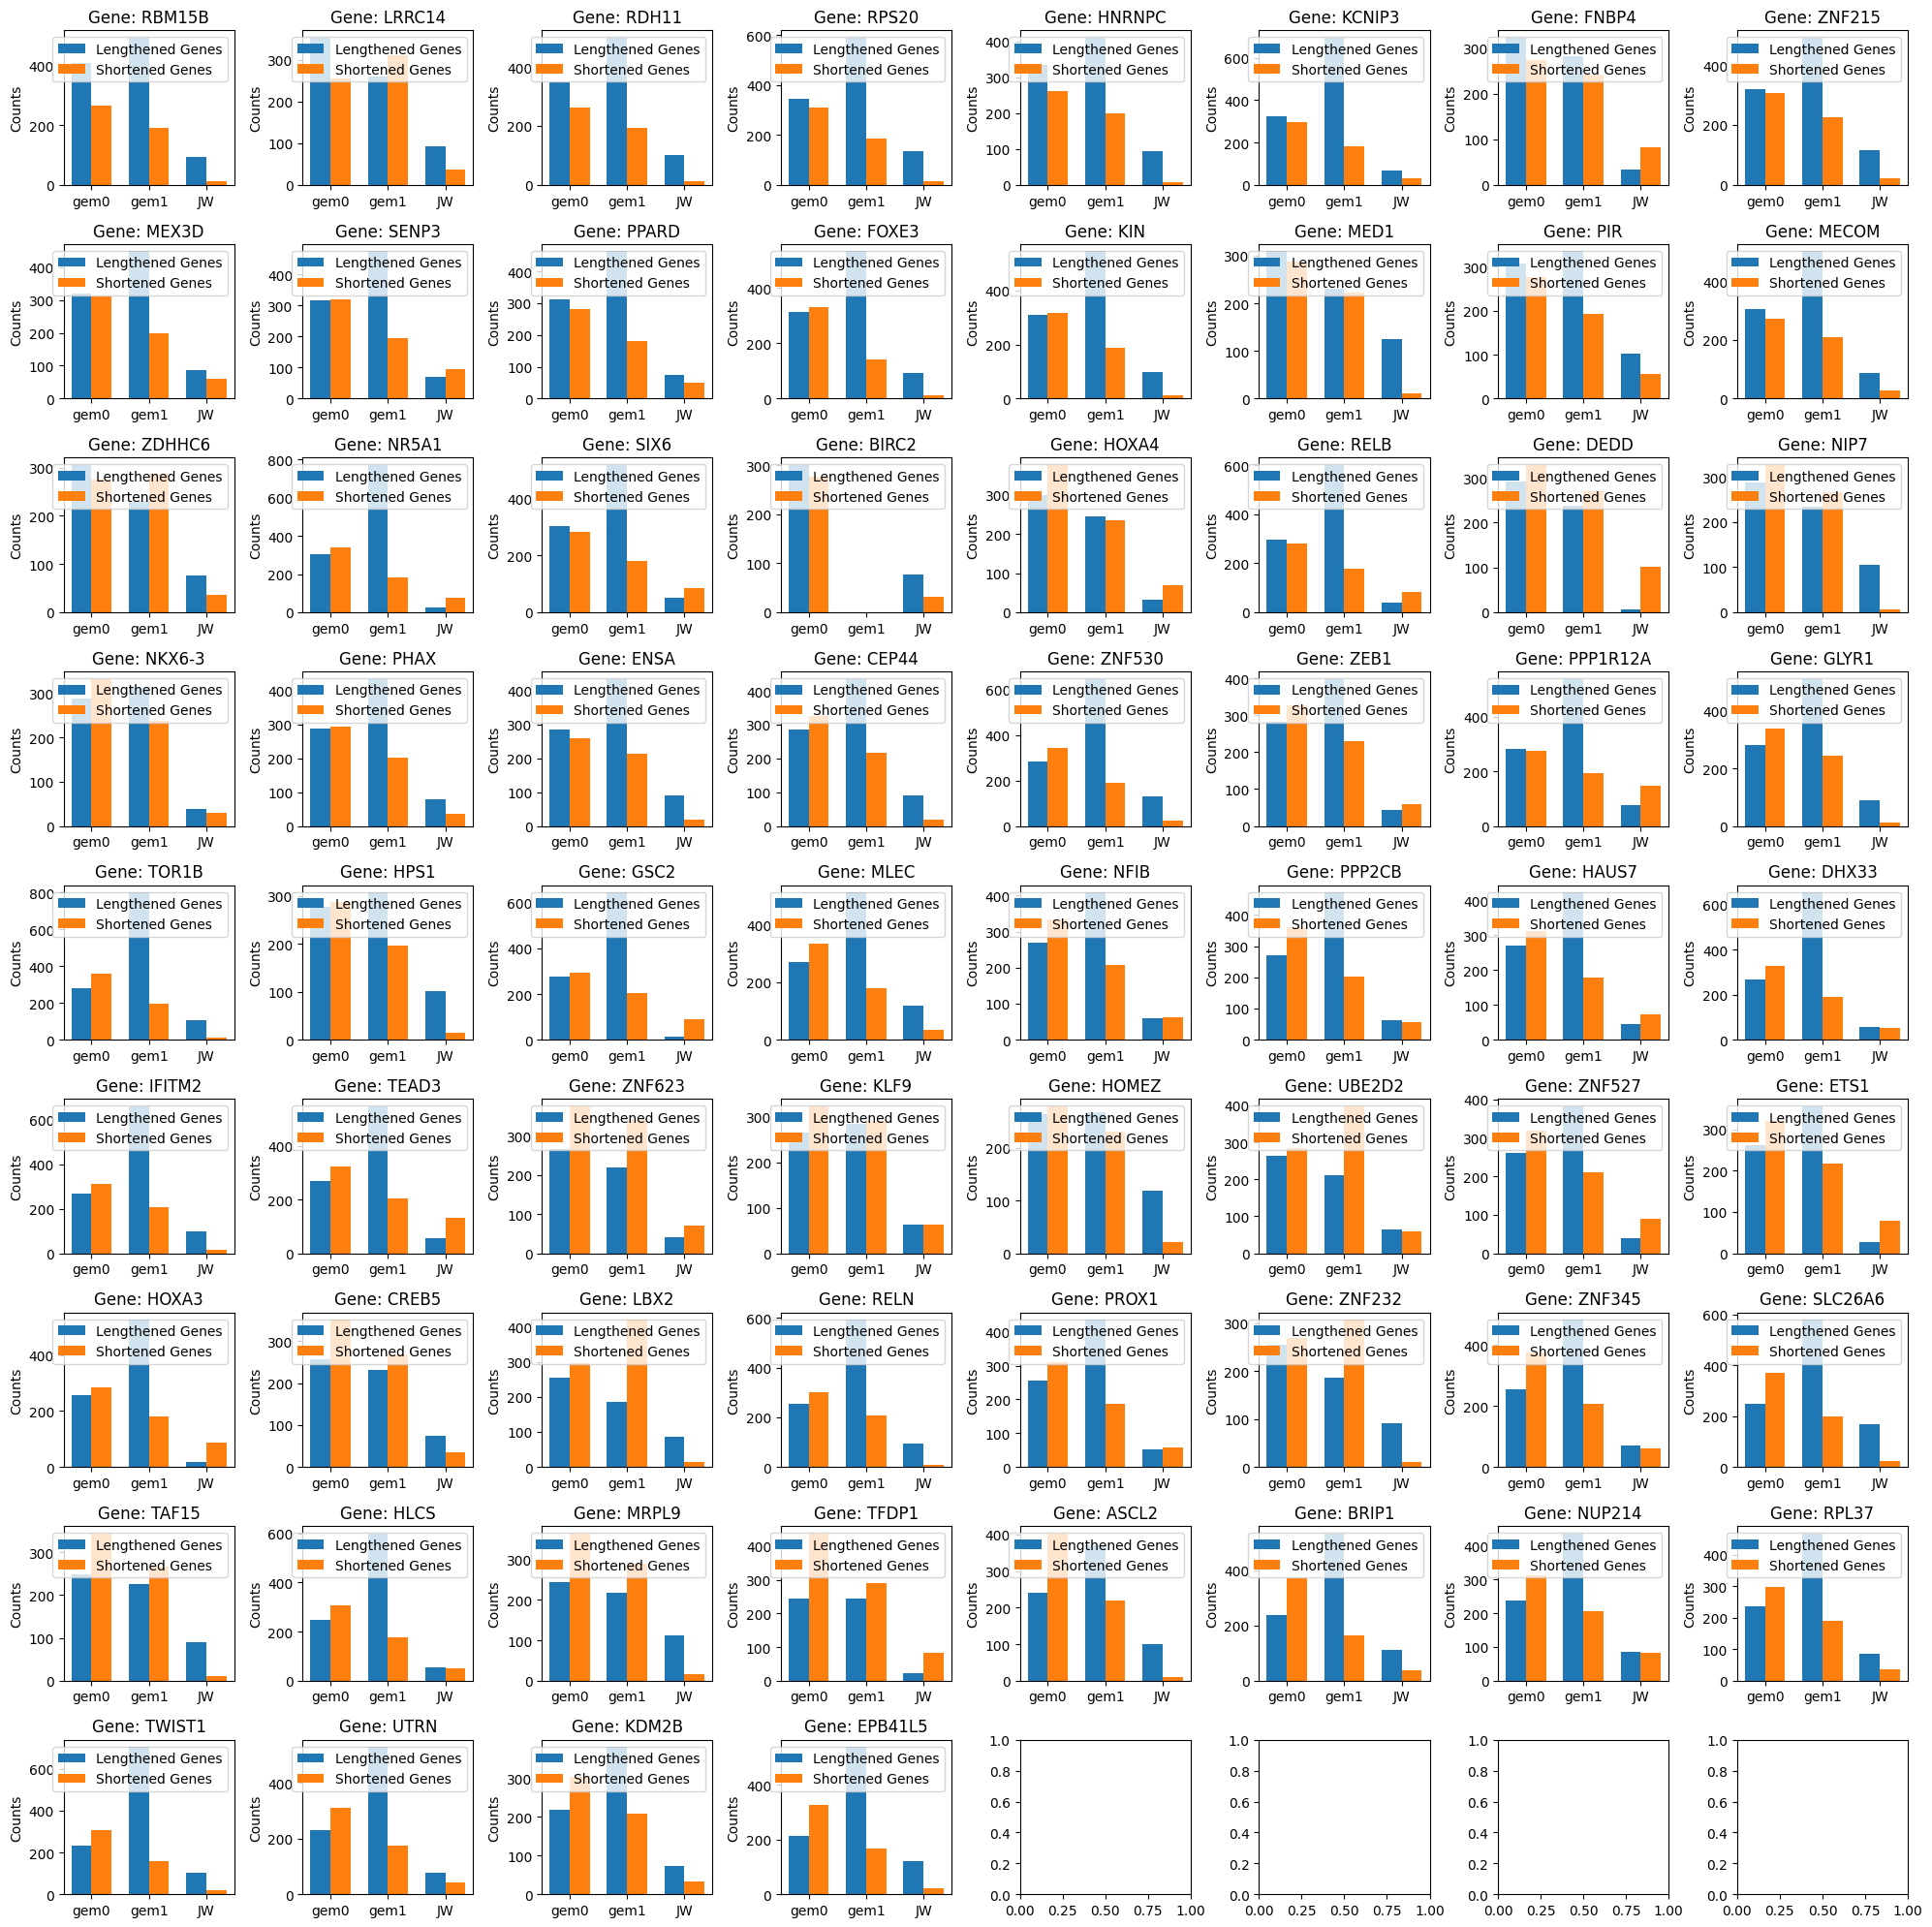

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Combine dataframes
# Assuming the dataframes have been aligned so that they contain the same set of genes
all_genes = gem0_stratified_df['Gene']

# Create subplots
fig, axes = plt.subplots(9, 8, figsize=(20, 20))
axes = axes.flatten()

for idx, gene in enumerate(all_genes):
    ax = axes[idx]

    # Data for gene
    gem0_data = gem0_stratified_df[gem0_stratified_df['Gene'] == gene]
    gem1_data = gem1_stratified_df[gem1_stratified_df['Gene'] == gene]
    JW_data = JW_df[JW_df['Gene'] == gene]

    # Create x and y values for plotting
    labels = ['gem0', 'gem1', 'JW']
    lengthened_values = [gem0_data['lengthened_genes'].values[0], gem1_data['lengthened_genes'].values[0], JW_data['lengthened_genes'].values[0]]
    shortened_values = [gem0_data['shortened_genes'].values[0], gem1_data['shortened_genes'].values[0], JW_data['shortened_genes'].values[0]]

    x = np.arange(len(labels))
    width = 0.35

    # Create bars
    ax.bar(x - width/2, lengthened_values, width, label='Lengthened Genes')
    ax.bar(x + width/2, shortened_values, width, label='Shortened Genes')

    # Additional plot settings
    ax.set_ylabel('Counts')
    ax.set_title(f'Gene: {gene}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

# Remove any unused subplots
for idx in range(len(all_genes), 68):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


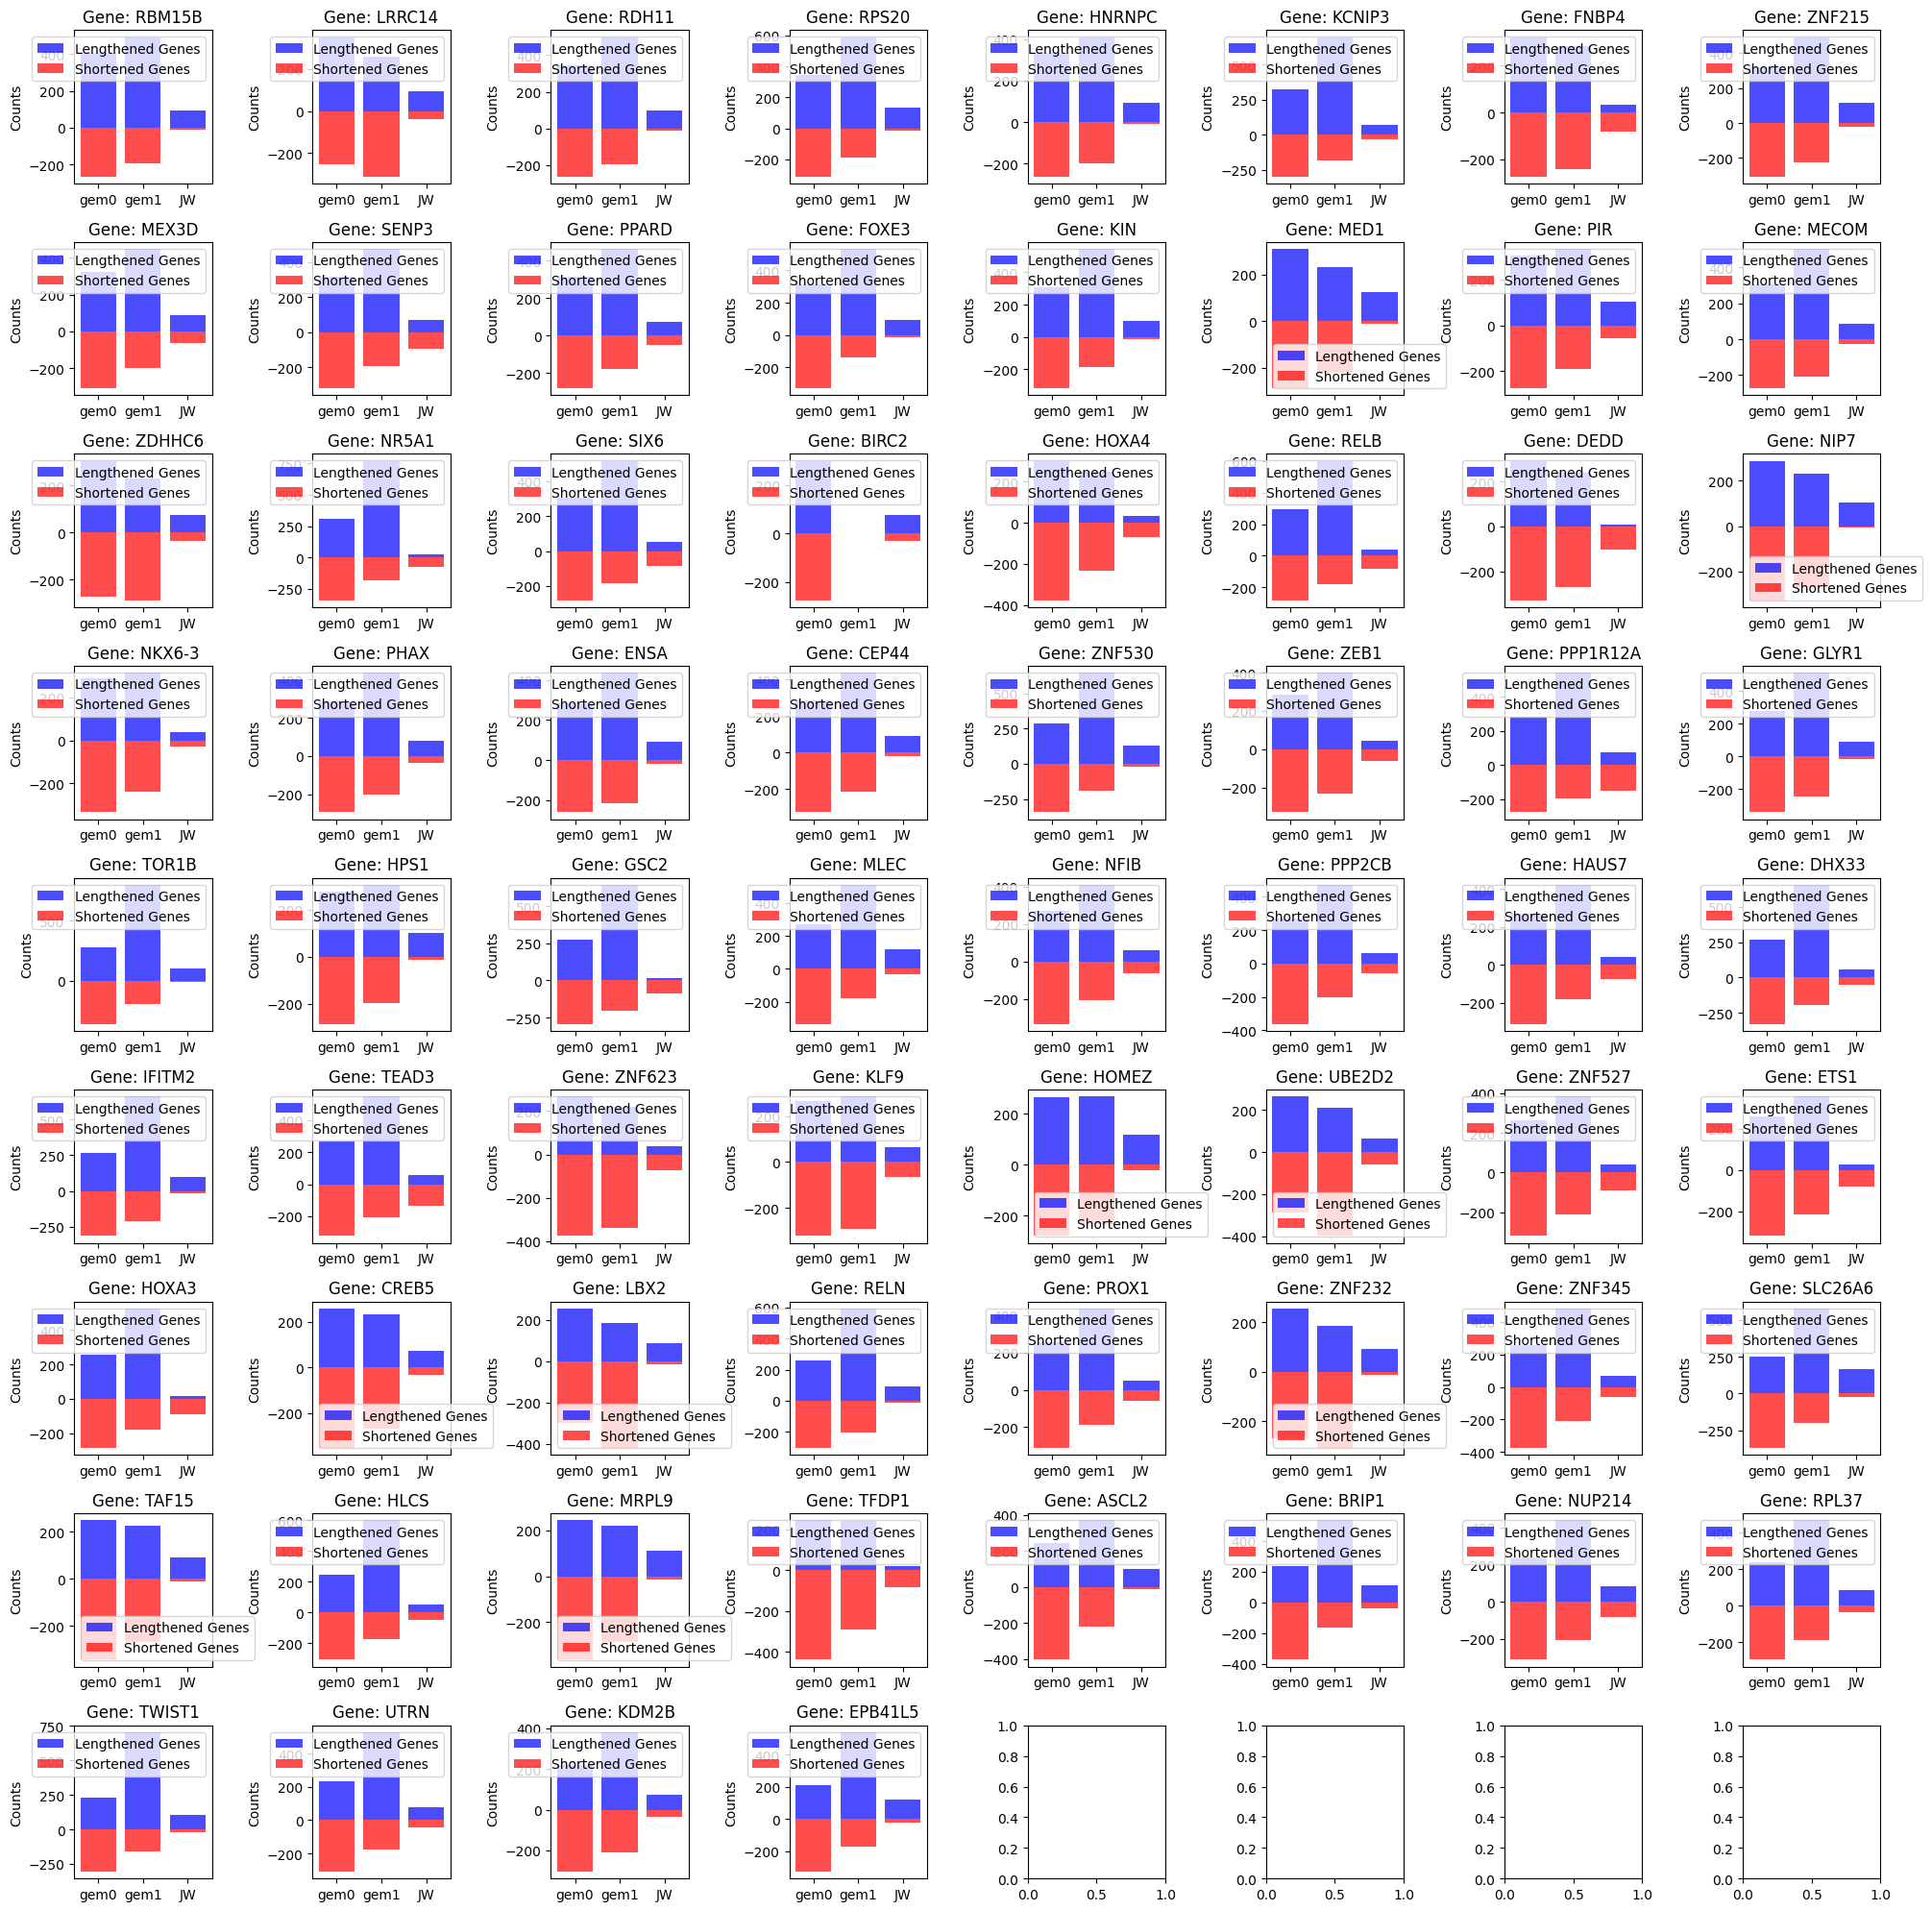

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming gem0_stratified_df, gem1_stratified_df, and JW_df are your DataFrames

# Flatten axes array
all_genes = gem0_stratified_df['Gene']

fig, axes = plt.subplots(9, 8, figsize=(20, 20))
axes = axes.flatten()

# Loop over each gene to create its own subplot
for idx, gene in enumerate(all_genes):
    ax = axes[idx]

    # Prepare the data for the selected gene from each DataFrame
    gem0_data = gem0_stratified_df[gem0_stratified_df['Gene'] == gene].iloc[0]
    gem1_data = gem1_stratified_df[gem1_stratified_df['Gene'] == gene].iloc[0]
    JW_data = JW_df[JW_df['Gene'] == gene].iloc[0]

    lengthened_values = [gem0_data['lengthened_genes'], gem1_data['lengthened_genes'], JW_data['lengthened_genes']]
    shortened_values = [-gem0_data['shortened_genes'], -gem1_data['shortened_genes'], -JW_data['shortened_genes']]

    labels = ['gem0', 'gem1', 'JW']
    
    x = np.arange(len(labels))

    # Create the double-sided bar chart
    ax.bar(x, lengthened_values, color='lightblue', alpha=0.7, label='Lengthened Genes')
    ax.bar(x, shortened_values, color='lightred', alpha=0.7, label='Shortened Genes')

    # Set plot title and labels
    ax.set_title(f'Gene: {gene}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Counts')
    ax.legend()

# Remove unused subplots
for i in range(len(all_genes), 17 * 4):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


/tmp/ipykernel_56979/459627839.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(abs(int(y))) for y in yticks])


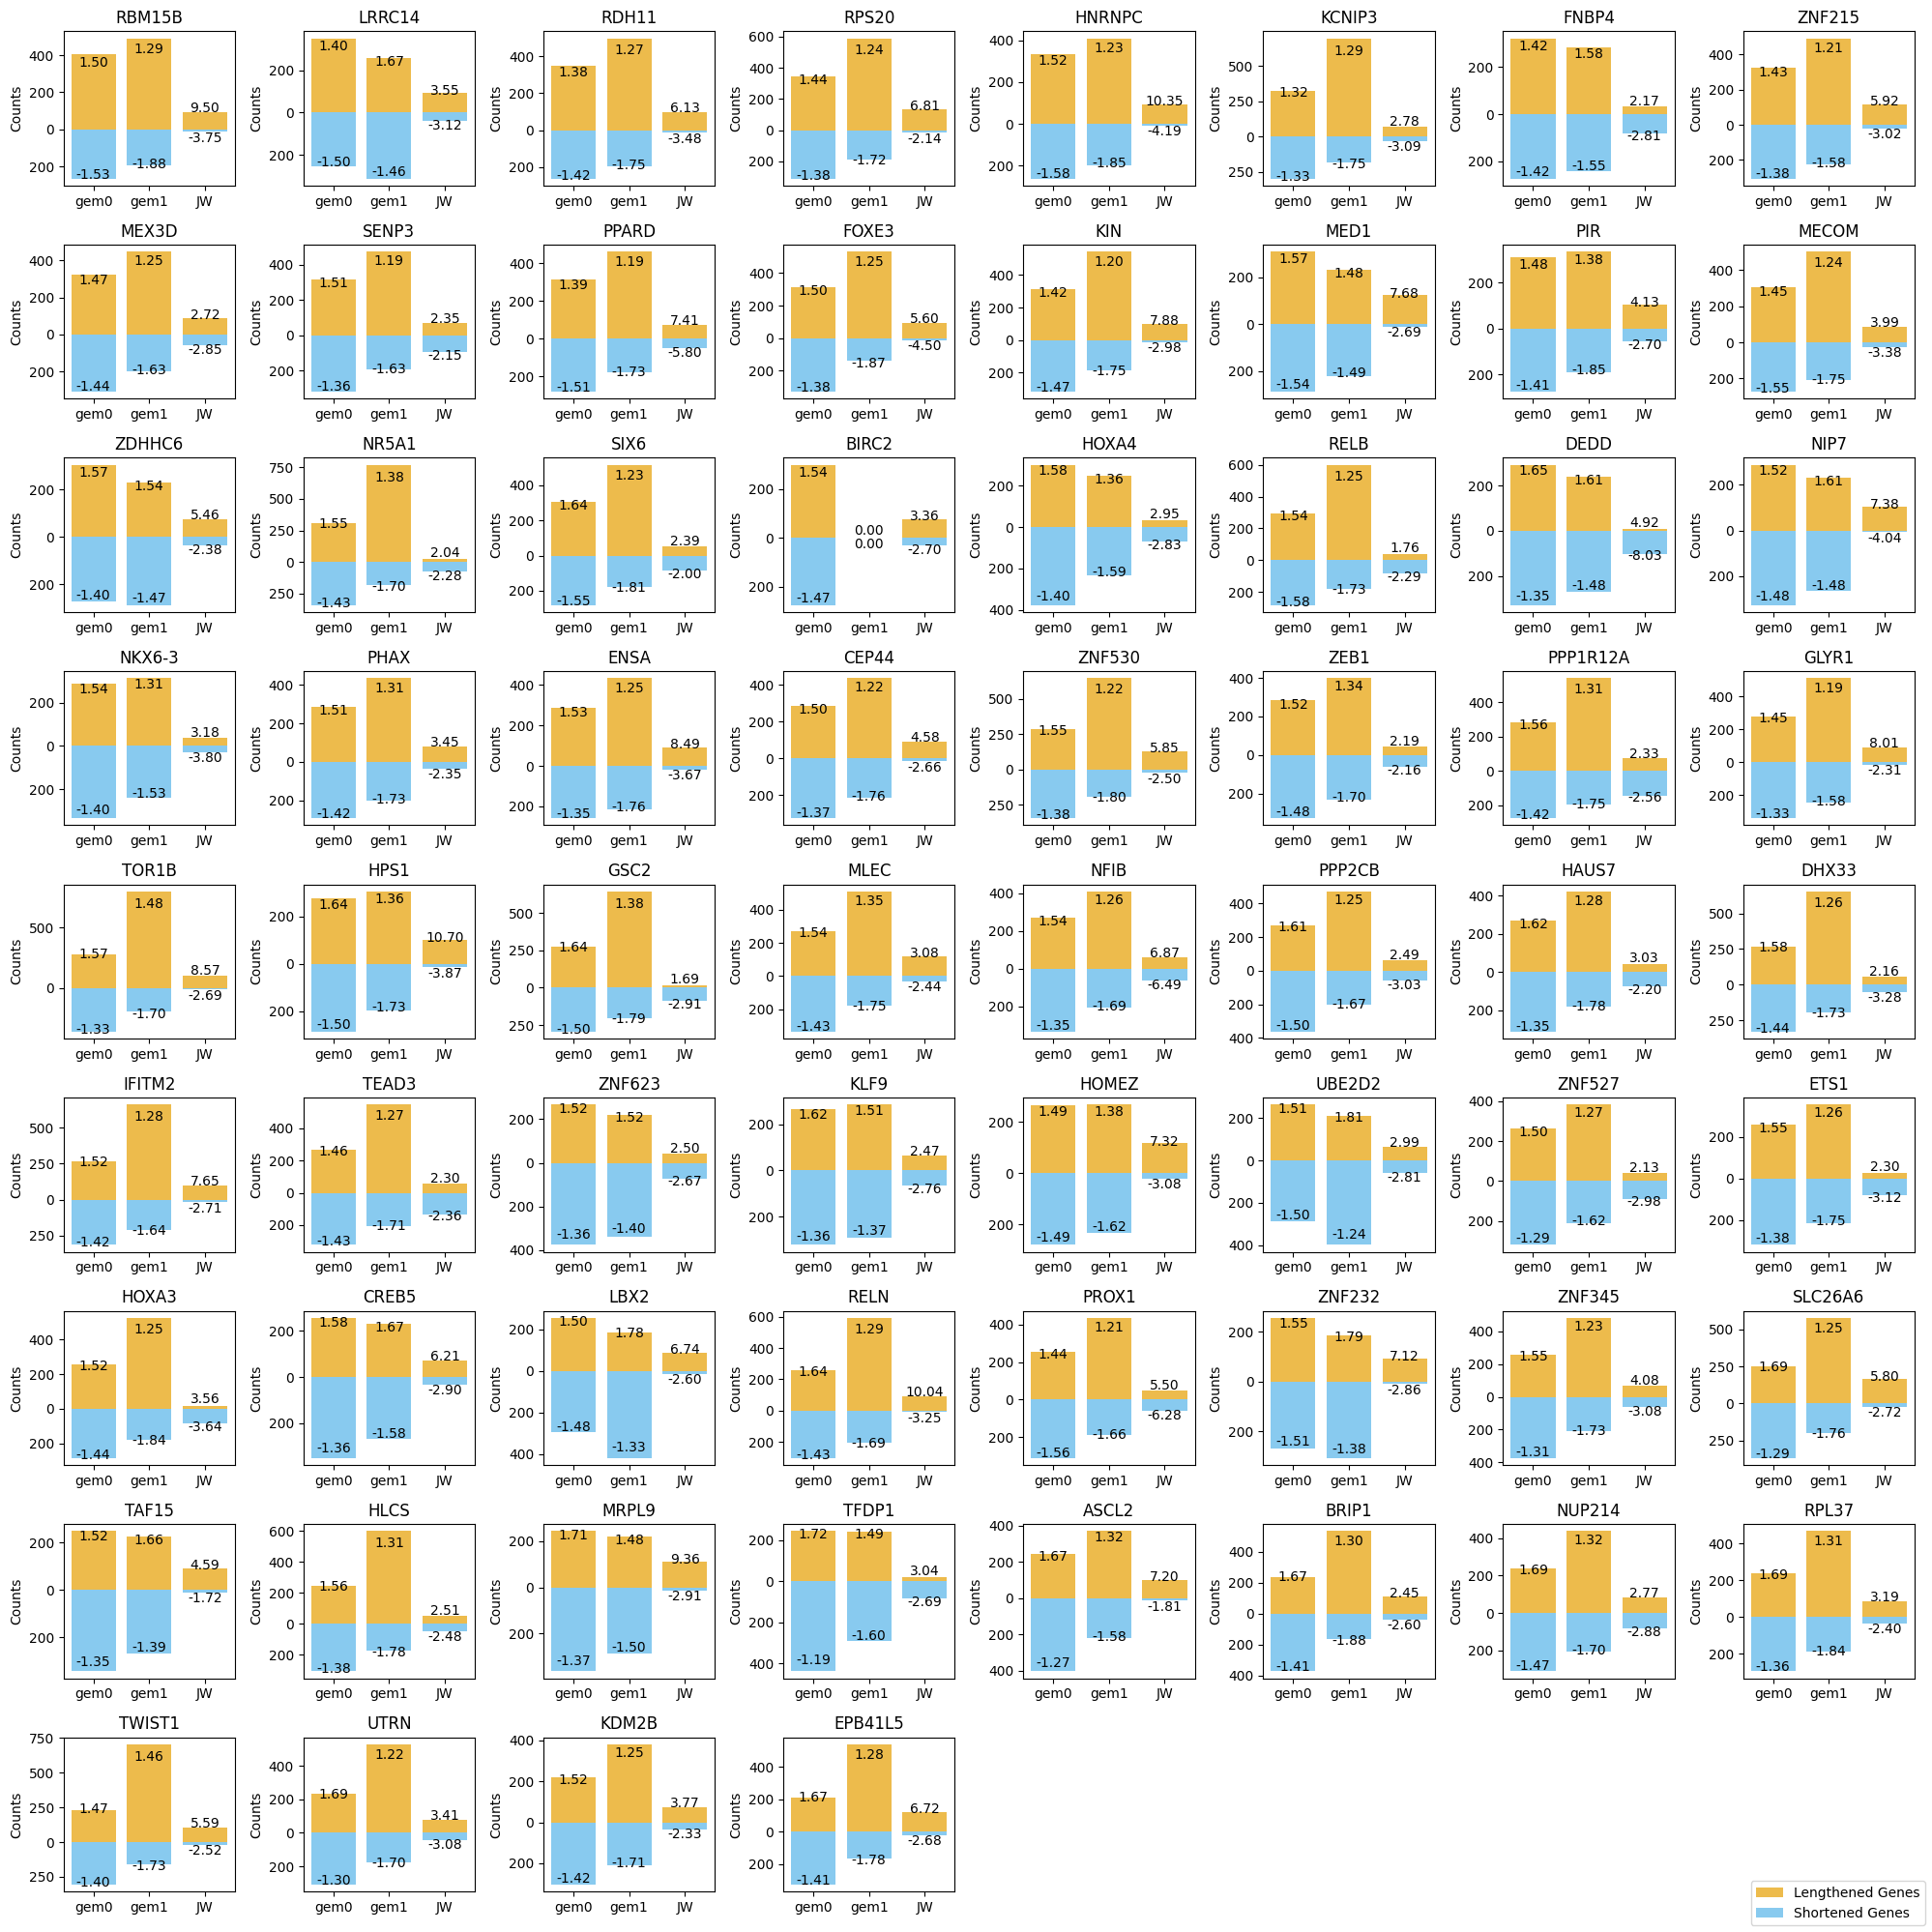

In [136]:
all_genes = gem0_stratified_df['Gene']

fig, axes = plt.subplots(9, 8, figsize=(20, 20))
axes = axes.flatten()

# Loop over each gene to create its own subplot
for idx, gene in enumerate(all_genes):
    ax = axes[idx]

    # Prepare the data for the selected gene from each DataFrame
    gem0_data = gem0_stratified_df[gem0_stratified_df['Gene'] == gene].iloc[0]
    gem1_data = gem1_stratified_df[gem1_stratified_df['Gene'] == gene].iloc[0]
    JW_data = JW_df[JW_df['Gene'] == gene].iloc[0]

    lengthened_values = [gem0_data['lengthened_genes'], gem1_data['lengthened_genes'], JW_data['lengthened_genes']]
    shortened_values = [-gem0_data['shortened_genes'], -gem1_data['shortened_genes'], -JW_data['shortened_genes']]
    distal_APA_effect = [gem0_data['distal_APA_effect'], gem1_data['distal_APA_effect'], JW_data['distal_APA_effect']]
    proximal_APA_effect = [gem0_data['proximal_APA_effect'], gem1_data['proximal_APA_effect'], JW_data['proximal_APA_effect']]

    labels = ['gem0', 'gem1', 'JW']
    
    x = np.arange(len(labels))

    # Create the double-sided bar chart
    ax.bar(x, lengthened_values, color='#E69F00', alpha=0.7)
    ax.bar(x, shortened_values, color='#56B4E9', alpha=0.7)

    # Add APA effect values on top of the bars
    for i, (lengthened, shortened, distal, proximal) in enumerate(zip(lengthened_values, shortened_values, distal_APA_effect, proximal_APA_effect)):
        ax.text(i, lengthened  - 0.2 * abs(lengthened), f'{distal:.2f}', ha='center', va='bottom')
        ax.text(i, shortened + 0.2 * abs(shortened), f'{proximal:.2f}', ha='center', va='top')

    # Set plot title and labels
    ax.set_title(f'{gene}')
    ax.set_xticks(x)
    # make sure y.ticks are positive
    yticks = ax.get_yticks()
    ax.set_yticklabels([str(abs(int(y))) for y in yticks])
    ax.set_xticklabels(labels)
    ax.set_ylabel('Counts')

# Remove unused subplots
for i in range(len(all_genes), 9 * 8):
    fig.delaxes(axes[i])

# Add one legend for the entire figure
fig.legend(['Lengthened Genes', 'Shortened Genes'], loc='lower right')
plt.tight_layout()
# handles, labels = ax.get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower right', bbox_transform=fig.transFigure)
plt.show()
